In [21]:
from braindecode.datasets import BaseConcatDataset, BaseDataset
import os

import numpy as np
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data


from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore

import numpy as np
import copy
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from scipy.interpolate import interp1d
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression as LR

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore
from braindecode.datasets import BaseConcatDataset, BaseDataset

from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from sklearn.utils import check_random_state

PATH = '/mnt/sleepx/'


# Params
NEG_SAMPLES = 128 # number of negative samples per positive sample
BATCH_SIZE = 1
POS_MIN = 1
NEG_MIN = 15
EPOCH_LEN = 7
NUM_SAMPLES = 2000
SUBJECTS = np.arange(83)
RECORDINGS = [1, 2]

In [23]:
random_state = 1234
n_jobs = 1
sfreq = 100
high_cut_hz = 30

window_size_s = 30
sfreq = 100
window_size_samples = window_size_s * sfreq



class SleepPhysionet(BaseConcatDataset):
    def __init__(
        self,
        subject_ids=None,
        recording_ids=None,
        preload=False,
        load_eeg_only=True,
        crop_wake_mins=30,
        crop=None,
    ):
        if subject_ids is None:
            subject_ids = range(83)
        if recording_ids is None:
            recording_ids = [1, 2]

        paths = fetch_data(
            subject_ids,
            recording=recording_ids,
            on_missing="warn",
            path='/mnt/sleepx',
        )

        all_base_ds = list()
        for p in paths:
            raw, desc = self._load_raw(
                p[0],
                p[1],
                preload=preload,
                load_eeg_only=load_eeg_only,
                crop_wake_mins=crop_wake_mins,
                crop=crop,
            )
            base_ds = BaseDataset(raw, desc)
            all_base_ds.append(base_ds)
        super().__init__(all_base_ds)

    @staticmethod
    def _load_raw(
        raw_fname,
        ann_fname,
        preload,
        load_eeg_only=True,
        crop_wake_mins=False,
        crop=None,
    ):
        ch_mapping = {
            "EOG horizontal": "eog",
            "Resp oro-nasal": "misc",
            "EMG submental": "misc",
            "Temp rectal": "misc",
            "Event marker": "misc",
        }
        exclude = list(ch_mapping.keys()) if load_eeg_only else ()

        raw = mne.io.read_raw_edf(raw_fname, preload=preload, exclude=exclude)
        annots = mne.read_annotations(ann_fname)
        raw.set_annotations(annots, emit_warning=False)

        if crop_wake_mins > 0:
            # Find first and last sleep stages
            mask = [x[-1] in ["1", "2", "3", "4", "R"] for x in annots.description]
            sleep_event_inds = np.where(mask)[0]

            # Crop raw
            tmin = annots[int(sleep_event_inds[0])]["onset"] - crop_wake_mins * 60
            tmax = annots[int(sleep_event_inds[-1])]["onset"] + crop_wake_mins * 60
            raw.crop(tmin=max(tmin, raw.times[0]), tmax=min(tmax, raw.times[-1]))

        # Rename EEG channels
        ch_names = {i: i.replace("EEG ", "") for i in raw.ch_names if "EEG" in i}
        raw.rename_channels(ch_names)

        if not load_eeg_only:
            raw.set_channel_types(ch_mapping)

        if crop is not None:
            raw.crop(*crop)

        basename = os.path.basename(raw_fname)
        subj_nb = int(basename[3:5])
        sess_nb = int(basename[5])
        desc = pd.Series({"subject": subj_nb, "recording": sess_nb}, name="")
       

        return raw, desc


random_state = 1234
n_jobs = -1
sfreq = 100
high_cut_hz = 30

EPOCH_LEN = 15

dataset = SleepPhysionet(
    subject_ids=SUBJECTS, recording_ids=RECORDINGS, crop_wake_mins=30
)

preprocessors = [
    Preprocessor(lambda x: x * 1e6),
    Preprocessor("filter", l_freq=None, h_freq=high_cut_hz, n_jobs=n_jobs),
]

# Transform the data
preprocess(dataset, preprocessors)


mapping = {  # We merge stages 3 and 4 following AASM standards.
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
}

windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples,
    preload= True,
    mapping=mapping,
)


preprocess(windows_dataset, [Preprocessor(zscore)])


Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-23-c14ddb70b149>:27: RuntimeWarning: This dataset contains subjects 0 to 82 with missing subjects [39, 68, 69, 78, 79]. Unknown subjects: 39, 68, 69, 78, 79.
  paths = fetch_data(
<ipython-input-23-c14ddb70b149>:27: RuntimeWarning: Requested recording 1 for subject 36 and/or 52, but it is not available in corpus.
  paths = fetch_data(
<ipython-input-23-c14ddb70b149>:27: RuntimeWarning: Requested recording 2 for subject 13, but it is not available in corpus.
  paths = fetch_data(


Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /mnt/sleepx/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure..

/anaconda/envs/torch/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3348000  =      0.000 ... 33480.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3447000  =      0.000 ... 34470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3060000  =      0.000 ... 30600.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3027000  =      0.000 ... 30270.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2850000  =      0.000 ... 28500.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2706000  =      0.000 ... 27060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3705000  =      0.000 ... 37050.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3606000  =      0.000 ... 36060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2010000  =      0.000 ... 20100.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3741000  =      0.000 ... 37410.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2481000  =      0.000 ... 24810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3036000  =      0.000 ... 30360.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2907000  =      0.000 ... 29070.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3813000  =      0.000 ... 38130.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3381000  =      0.000 ... 33810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3159000  =      0.000 ... 31590.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3423000  =      0.000 ... 34230.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3345000  =      0.000 ... 33450.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3294000  =      0.000 ... 32940.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3264000  =      0.000 ... 32640.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2775000  =      0.000 ... 27750.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2364000  =      0.000 ... 23640.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3147000  =      0.000 ... 31470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2916000  =      0.000 ... 29160.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3072000  =      0.000 ... 30720.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3009000  =      0.000 ... 30090.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2844000  =      0.000 ... 28440.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2832000  =      0.000 ... 28320.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5271000  =      0.000 ... 52710.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3432000  =      0.000 ... 34320.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3012000  =      0.000 ... 30120.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2856000  =      0.000 ... 28560.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5322000  =      0.000 ... 53220.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2823000  =      0.000 ... 28230.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2751000  =      0.000 ... 27510.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4569000  =      0.000 ... 45690.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3744000  =      0.000 ... 37440.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3018000  =      0.000 ... 30180.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3018000  =      0.000 ... 30180.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4746000  =      0.000 ... 47460.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2391000  =      0.000 ... 23910.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3291000  =      0.000 ... 32910.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3318000  =      0.000 ... 33180.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2715000  =      0.000 ... 27150.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5199000  =      0.000 ... 51990.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4953000  =      0.000 ... 49530.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5310000  =      0.000 ... 53100.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2847000  =      0.000 ... 28470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3024000  =      0.000 ... 30240.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4773000  =      0.000 ... 47730.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2934000  =      0.000 ... 29340.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3081000  =      0.000 ... 30810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3267000  =      0.000 ... 32670.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3369000  =      0.000 ... 33690.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3039000  =      0.000 ... 30390.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3384000  =      0.000 ... 33840.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4800000  =      0.000 ... 48000.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2763000  =      0.000 ... 27630.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2454000  =      0.000 ... 24540.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz



[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3084000  =      0.000 ... 30840.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3537000  =      0.000 ... 35370.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4557000  =      0.000 ... 45570.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3021000  =      0.000 ... 30210.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5661000  =      0.000 ... 56610.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3939000  =      0.000 ... 39390.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4440000  =      0.000 ... 44400.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4743000  =      0.000 ... 47430.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2907000  =      0.000 ... 29070.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2892000  =      0.000 ... 28920.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2448000  =      0.000 ... 24480.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2673000  =      0.000 ... 26730.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4518000  =      0.000 ... 45180.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5193000  =      0.000 ... 51930.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5610000  =      0.000 ... 56100.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3177000  =      0.000 ... 31770.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3213000  =      0.000 ... 32130.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3228000  =      0.000 ... 32280.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2757000  =      0.000 ... 27570.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2352000  =      0.000 ... 23520.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2640000  =      0.000 ... 26400.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2088000  =      0.000 ... 20880.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2847000  =      0.000 ... 28470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    0.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3582000  =      0.000 ... 35820.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3243000  =      0.000 ... 32430.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3621000  =      0.000 ... 36210.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3486000  =      0.000 ... 34860.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2946000  =      0.000 ... 29460.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3045000  =      0.000 ... 30450.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3555000  =      0.000 ... 35550.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6393000  =      0.000 ... 63930.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6080999  =      0.000 ... 60809.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5721000  =      0.000 ... 57210.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3297000  =      0.000 ... 32970.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3114000  =      0.000 ... 31140.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3885000  =      0.000 ... 38850.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3300000  =      0.000 ... 33000.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3237000  =      0.000 ... 32370.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2847000  =      0.000 ... 28470.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 2982000  =      0.000 ... 29820.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3258000  =      0.000 ... 32580.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3150000  =      0.000 ... 31500.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5148000  =      0.000 ... 51480.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3441000  =      0.000 ... 34410.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3138000  =      0.000 ... 31380.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3267000  =      0.000 ... 32670.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3654000  =      0.000 ... 36540.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3381000  =      0.000 ... 33810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3702000  =      0.000 ... 37020.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3276000  =      0.000 ... 32760.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3258000  =      0.000 ... 32580.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3522000  =      0.000 ... 35220.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5436000  =      0.000 ... 54360.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3692999  =      0.000 ... 36929.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4041000  =      0.000 ... 40410.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6114000  =      0.000 ... 61140.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4971000  =      0.000 ... 49710.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3177000  =      0.000 ... 31770.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4326000  =      0.000 ... 43260.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5466000  =      0.000 ... 54660.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3180000  =      0.000 ... 31800.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3318000  =      0.000 ... 33180.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3810000  =      0.000 ... 38100.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6135000  =      0.000 ... 61350.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 7890000  =      0.000 ... 78900.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5790000  =      0.000 ... 57900.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6078000  =      0.000 ... 60780.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5979000  =      0.000 ... 59790.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5901000  =      0.000 ... 59010.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3054000  =      0.000 ... 30540.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5145000  =      0.000 ... 51450.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4521000  =      0.000 ... 45210.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4230000  =      0.000 ... 42300.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.9s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3720000  =      0.000 ... 37200.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3081000  =      0.000 ... 30810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3381000  =      0.000 ... 33810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 8000999  =      0.000 ... 80009.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6956999  =      0.000 ... 69569.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6627000  =      0.000 ... 66270.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3177000  =      0.000 ... 31770.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 6131999  =      0.000 ... 61319.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3135000  =      0.000 ... 31350.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.6s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5106000  =      0.000 ... 51060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.0s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3972000  =      0.000 ... 39720.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    3.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3954000  =      0.000 ... 39540.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3720000  =      0.000 ... 37200.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.5s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3681000  =      0.000 ... 36810.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3852000  =      0.000 ... 38520.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 3552000  =      0.000 ... 35520.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 5106000  =      0.000 ... 51060.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.4s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Reading 0 ... 4083000  =      0.000 ... 40830.000 secs...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    2.2s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed:    1.7s finished


0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1116 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1116 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1088 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1088 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1150 matching

/anaconda/envs/torch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
class RecordingSampler(Sampler):
    def __init__(self, metadata, random_state=None, epoch_len=7):

        self.metadata = metadata
        self._init_info()
        self.rng = check_random_state(random_state)
        self.epoch_len = epoch_len

    def _init_info(self):
        keys = ["subject", "recording"]

        self.metadata = self.metadata.reset_index().rename(
            columns={"index": "window_index"}
        )
        self.info = (
            self.metadata.reset_index()
            .groupby(keys)[["index", "i_start_in_trial"]]
            .agg(["unique"])
        )
        self.info.columns = self.info.columns.get_level_values(0)

    def sample_recording(self):
        """Return a random recording index."""
        return self.rng.choice(self.n_recordings)

    def sample_window(self, rec_ind=None):
        """Return a specific window."""
        if rec_ind is None:
            rec_ind = self.sample_recording()
        win_ind = self.rng.choice(
            self.info.iloc[rec_ind]["index"][self.epoch_len // 2 : -self.epoch_len // 2]
        )
        return win_ind, rec_ind

    def __iter__(self):
        raise NotImplementedError

    @property
    def n_recordings(self):
        return self.info.shape[0]


class RelativePositioningSampler(RecordingSampler):
    def __init__(
        self,
        metadata,
        tau_pos,
        tau_neg,
        n_examples,
        same_rec_neg=True,
        random_state=None,
        epoch_len=7,
        neg_samples = NEG_SAMPLES
    ):
        super().__init__(metadata, random_state=random_state, epoch_len=epoch_len)

        self.tau_pos = tau_pos
        self.tau_neg = tau_neg
        self.epoch_len = epoch_len
        self.neg_samples = neg_samples
        self.n_examples = n_examples
        self.same_rec_neg = same_rec_neg

    def _sample_pair(self):
        
        """Sample a pair of two windows."""
        # Sample first window
        win_ind1, rec_ind1 = self.sample_window()
        
        ts1 = self.metadata.iloc[win_ind1]["i_start_in_trial"]
        ts = self.info.iloc[rec_ind1]["i_start_in_trial"]

        epoch_min = self.info.iloc[rec_ind1]["i_start_in_trial"][self.epoch_len // 2]
        epoch_max = self.info.iloc[rec_ind1]["i_start_in_trial"][-self.epoch_len // 2]

        if self.same_rec_neg:
            mask = ((ts <= ts1 - self.tau_neg) & (ts >= epoch_min)) | (
                (ts >= ts1 + self.tau_neg) & (ts <= epoch_max)
            )

        if sum(mask) == 0:
            raise NotImplementedError
        
        win_ind2 = []
        for i in range(self.neg_samples):
            win_ind2.append(self.rng.choice(self.info.iloc[rec_ind1]["index"][mask]))
        
        return win_ind1, win_ind2

    def __iter__(self):

        for i in range(self.n_examples):
            yield self._sample_pair()

    def __len__(self):
        return self.n_examples

class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target."""

    def __init__(self, list_of_ds, epoch_len=7):
        super().__init__(list_of_ds)
        self.return_pair = True
        self.epoch_len = epoch_len

    def __getitem__(self, index):

        pos, neg = index
        pos_data = []

        for i in range(-(self.epoch_len // 2), self.epoch_len // 2 + 1):
            pos_data.append(super().__getitem__(pos + i)[0])

        pos_data = np.stack(pos_data, axis=0) # (7, 2, 3000)

        
        cont_neg_data = []
        for idx in neg:
            neg_data = []
            print(f"idx: {idx}")
            for i in range(-(self.epoch_len // 2), self.epoch_len // 2 + 1):
                neg_data.append(super().__getitem__(idx + i)[0])

            neg_data = np.stack(neg_data, axis=0) # (7, 2, 3000)
            cont_neg_data.append(neg_data)
        cont_neg_data = np.stack(cont_neg_data, axis=0) # (128, 7, 2, 3000)

        return pos_data, cont_neg_data

rng = np.random.RandomState(1234)
subjects = np.unique(windows_dataset.description["subject"])
sub_pretext = rng.choice(subjects, 58, replace=False)
sub_train = sorted(
    rng.choice(sorted(list(set(subjects) - set(sub_pretext))), 10, replace=False)
)
sub_test = sorted(list(set(subjects) - set(sub_pretext) - set(sub_train)))

splitted = dict()

splitted["pretext"] = RelativePositioningDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_pretext],
    epoch_len = EPOCH_LEN
)


In [27]:
class TuneDataset(BaseConcatDataset):
    """BaseConcatDataset for train and test"""

    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)

    def __getitem__(self, index):

        X = super().__getitem__(index)[0]
        y = super().__getitem__(index)[1]

        return X, y

splitted["train"] = TuneDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_train]
)

splitted["test"] = TuneDataset(
    [ds for ds in windows_dataset.datasets if ds.description["subject"] in sub_test]
)

In [28]:
splitted["train"].get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,recording
0,0,2706000,2709000,0,12,1
1,1,2709000,2712000,0,12,1
2,2,2712000,2715000,0,12,1
3,3,2715000,2718000,0,12,1
4,4,2718000,2721000,0,12,1
...,...,...,...,...,...,...
1123,53,5991000,5994000,0,72,2
1124,54,5994000,5997000,0,72,2
1125,55,5997000,6000000,0,72,2
1126,56,6000000,6003000,0,72,2


In [38]:
splitted["pretext"].get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,recording
0,0,2883000,2886000,0,0,1
1,1,2886000,2889000,0,0,1
2,2,2889000,2892000,0,0,1
3,3,2892000,2895000,0,0,1
4,4,2895000,2898000,0,0,1
...,...,...,...,...,...,...
1178,55,6603000,6606000,0,81,2
1179,56,6606000,6609000,0,81,2
1180,57,6609000,6612000,0,81,2
1181,58,6612000,6615000,0,81,2


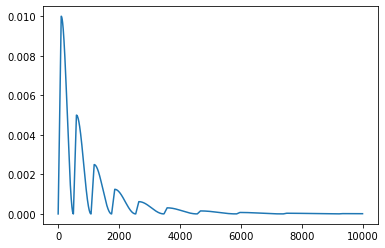

In [32]:
%matplotlib inline

from multi_epoch.utils import CosineAnnealingWarmupRestarts
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

model = models.resnet18()

a = torch.randn((10, 10), requires_grad=True)
b = torch.randn((10, 10), requires_grad=True)
c = a+b

optimizer = torch.optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps = 500, cycle_mult = 1.2, max_lr = 0.01, min_lr = 5e-6, warmup_steps = 100, gamma = 0.5)

step = 0
lrs = []

for i in range(10000):
    step += 1
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)


In [12]:
subjects.metadata()

NameError: name 'subjects' is not defined